# Ventas en USD
## Limpieza de los datos

Capacitación: Gobernanza de Datos - GCBA

#### **Librerias y Setup del Notebook**

In [1]:
# Libs principales
import pandas as pd
import numpy as np

# DataViz libs
import matplotlib.pyplot as plt
import seaborn as sns

# Lib. Utiles
from datetime import datetime

# Setup del Notebooks
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Objetivos del Proyecto


**Grupo Perfil Tecnico**
- En Base al excel “Actividad Ventas en Dolares” identificar posibles análisis a realizar con los datos actuales.

- Con qué problemas de calidad de datos nos encontramos y cómo podríamos resolverlos? 

- Calcular la venta en dólares para los distintos productos del total de la base y para los últimos 3 meses del 2020. Deben buscar una base externa para resolver esta cuestión. Adjuntar un excel con sus gráficos, resultados y base incorporada y fuente. Contestar: cómo resolvieron la normalización de los datos?

- Hacer foco en cuestiones de negocios, qué decisiones **podemos** y **no podemos** tomar con la data actual? Qué información agregaría o recomendaría agregar?

- Adjuntar excel con sus gráficos y resultados, y también un word con sus respuestas teóricas. 

***

### Agenda - Limpieza de Datos

1. Encoding/Decoding caracteres especiales en las variables categoricas;
2. Verificar, corregir o dropar columnas con muchos datos faltantes;
3. Parsear correctamente columna `Date (YYYYMMDD)`;
4. Conectar base de `monedas` (cambio/forex), traendo datos del cambio diario, a travez da la fecha presente en `Date (YYYYMMDD)`;
5. Analisis de los datos (en otro Notebook).

### **Cargando dataset de `ventas` en Jupyter Nb**

In [2]:
# Caergando archivo en formato Excel y guardandolo en formato csv

# pd.read_excel('../data/ventas_usd.xlsx', engine = 'openpyxl').to_csv('../data/ventas_usd.csv')

In [3]:
# Cargando dataset en Jupyter, version csv

ventas = pd.read_csv("../data/ventas_usd.csv", index_col = 'Unnamed: 0', encoding = 'utf-8')
ventas.head(3)

,Delivery_Id,amount,Pais/Moneda,quantity,units,title,subtitle,ean (identificador producto),brand,flavor,variant,first_driver,second_driver,third_driver,package_type,volume_quantity,volume_unit,nutritional_information,category_code,category_name,category_color,retail_amount,Date (YYYYMMDD)
0,1,14.0,México,6,1,NaN,Coca-Cola Sabor Original,7501055300075,Coca-Cola Sabor Original,NaN,NaN,NaN,NaN,NaN,NaN,355.0,mL,NaN,BEBIDAS,BEBIDAS,F7E173,14.0,20200708-171056676
1,1,14.0,México,6,1,NaN,Coca-Cola Sabor Original,7501055300075,Coca-Cola Sabor Original,NaN,NaN,NaN,NaN,NaN,NaN,355.0,mL,NaN,BEBIDAS,BEBIDAS,F7E173,14.0,20200708-171056676
2,2,94.0,Argentina,2,1,NaN,Marolio Duraznos en Mitades,7797470001998,Marolio,NaN,Duraznos en Mitades,NaN,NaN,NaN,,820.0,g,NaN,ALMACEN,ALMACÃ‰N,FFCB3D,94.0,20200708-171056676


## Limpieza de los datos

### Limpiando problemas con caracteres especiales

El objetivo de esta sección es limpiar los datos de tipo `string` que fueron parseados con caracteres especiales. 

Por ejemplo:

`Ala LÃ­quido Lavarropas Baja Espuma` ➞ `Ala Líquido Lavarropas Baja Espuma`

In [4]:
# Filtrando DF por columnas de tipo "Pandas Object" (string)

ventas_str = ventas[list(ventas.select_dtypes('object').columns)]
# ventas_str.head()

In [5]:
# ventas_str[ventas_str.apply(lambda x: x.str.contains('Ã'))].head()

In [6]:
### Conteo de strings unicas que contienen caracteres especiales y dificultan la lectura

# Filtando columnas que contienen caracteres especiales
ventas_str_especiales = ventas_str[ventas_str.apply(lambda x: x.str.contains('Ã'))]

# Proseguiendo con el conteo
ventas_str_especiales_conteo = ventas_str_especiales.nunique().loc[ventas_str_especiales.nunique() > 0]                          
ventas_str_especiales_conteo

subtitle         1995
brand             154
flavor             11
variant          1411
third_driver        3
package_type        7
category_name      28
dtype: int64

In [7]:
# Listando nombre de las columnas que contienen caracteres especiales
ventas_str_especiales_cols = ventas_str_especiales_conteo.index.tolist()

# ventas_str_especiales_cols

In [8]:
# Transformando caracteres especiales, de formato uft-8 a ascii
for col in ventas_str_especiales_cols:
    ventas[col] = ventas[col].str.encode('utf-8').str.decode('ascii', 'ignore')
    
    # Validando la transformación
    ventas_col_carac_esp = ventas[ventas[col].str.contains('Ã', na = False)]
    ventas_col_carac_esp_conteo = ventas_col_carac_esp.nunique().loc[ventas_col_carac_esp.nunique() > 0]
    
    assert len(ventas_col_carac_esp_conteo) == 0
    
# Visualizando el DF modificado
ventas.head(3)

,Delivery_Id,amount,Pais/Moneda,quantity,units,title,subtitle,ean (identificador producto),brand,flavor,variant,first_driver,second_driver,third_driver,package_type,volume_quantity,volume_unit,nutritional_information,category_code,category_name,category_color,retail_amount,Date (YYYYMMDD)
0,1,14.0,México,6,1,NaN,Coca-Cola Sabor Original,7501055300075,Coca-Cola Sabor Original,NaN,NaN,NaN,NaN,NaN,NaN,355.0,mL,NaN,BEBIDAS,BEBIDAS,F7E173,14.0,20200708-171056676
1,1,14.0,México,6,1,NaN,Coca-Cola Sabor Original,7501055300075,Coca-Cola Sabor Original,NaN,NaN,NaN,NaN,NaN,NaN,355.0,mL,NaN,BEBIDAS,BEBIDAS,F7E173,14.0,20200708-171056676
2,2,94.0,Argentina,2,1,NaN,Marolio Duraznos en Mitades,7797470001998,Marolio,NaN,Duraznos en Mitades,NaN,NaN,NaN,,820.0,g,NaN,ALMACEN,ALMACN,FFCB3D,94.0,20200708-171056676


### Datos faltantes

In [9]:
# Chequeando cantidad de datos faltantes en numero absoluto
# ventas.isna().sum()[ventas.isna().sum() > 0]

# Chequeando cantidad de datos faltantes, en proporcioón
ventas.isna().sum()[ventas.isna().sum() / ventas.shape[0] > .75] / ventas.shape[0]

title                      0.997880
flavor                     0.959517
first_driver               0.997880
second_driver              0.995461
third_driver               0.997500
nutritional_information    0.763484
dtype: float64

Las columnas con muchos datos faltantes no contribuyen para ese analisis y complican la visualización de la tabla. Vamos droparlas.

In [10]:
# Listando columnas para dropear
cols_to_drop = ventas.isna().sum()[ventas.isna().sum() / ventas.shape[0] > .8].index.to_list()
cols_to_drop

['title', 'flavor', 'first_driver', 'second_driver', 'third_driver']

In [11]:
# Dropando columnas con muchos datos faltantes
ventas.drop(cols_to_drop, axis = 1, inplace = True)

In [12]:
# Review del dataset
# ventas.head(5)

### Organizando la variable `Date`

In [13]:
# Limpiando string de fecha para obtener apenas el día
fecha = (np.array(ventas['Date (YYYYMMDD)'].str.partition('-'))[:, 0])
# hora = (np.array(ventas['Date (YYYYMMDD)'].str.partition('-'))[:, 2])

ventas['fecha'] = pd.to_datetime(fecha)

Guardamos la fecha más antigua de nuestro dataset de ventas `fecha_min`, bien como la fecha más reciente `fecha_max` para posteriormente filtrar la base de dados de `monedas`, otimizando para operacionalizar apenas sobre los datos necesários.

In [14]:
# Guargando fecha_min (primer día de la tabla Ventas) y fecha_max (útima día de la tabla Ventas)
fecha_min, fecha_max = ventas['fecha'].min(), ventas['fecha'].max()

fecha_min, fecha_max

(Timestamp('2020-07-01 00:00:00'), Timestamp('2021-04-18 00:00:00'))

In [15]:
# sorted(cambio_dates['currency'].unique())

### Padronizando informacion de siglas _forex_

En el dataset de `ventas` tenemos la información información del País/Moneda (variable `Pais/Moneda`), pero no está en el formato adecuado de cambios _forex_. Necesitamos mapear la columna y transformar la strings de países/monedas a sus respectivas siglas _forex_.

In [16]:
lista_monedas = ventas['Pais/Moneda'].unique().tolist()
siglas = ['MXN', 'ARS', 'PEN', 'COP', 'UYU', 'BRL', 'CLP', 'DOP', 'EUR', 'KES', 'EGP', 'VND', 'MYR', 'USD']

In [17]:
len(lista_monedas) == len(siglas) # Chequeando si todos las monedas tienen siglas

True

In [18]:
# Creando diccionario Pais x Sigla
pais_sigla_dict = dict(zip(lista_monedas, siglas))
pais_sigla_dict

{'México': 'MXN',
 'Argentina': 'ARS',
 'Perú': 'PEN',
 'Colombian Peso': 'COP',
 'Peso Uruguayo': 'UYU',
 'Real Brasilero': 'BRL',
 'Peso Chileno': 'CLP',
 'Dominican Peso': 'DOP',
 'Euro': 'EUR',
 'Kenya': 'KES',
 'Egipto': 'EGP',
 'Vietnam': 'VND',
 'Malasia': 'MYR',
 'Estados Unidos': 'USD'}

Con el dicionário de mapeo seteado correctamente, podemos seguir con el mapeo y agregar la información al dataset en una nueva variable, `currency`.

In [19]:
# Creando columna con sigla FOREX
ventas['currency'] = ventas['Pais/Moneda'].map(pais_sigla_dict)

In [20]:
ventas.head(3)

,Delivery_Id,amount,Pais/Moneda,quantity,units,subtitle,ean (identificador producto),brand,variant,package_type,volume_quantity,volume_unit,nutritional_information,category_code,category_name,category_color,retail_amount,Date (YYYYMMDD),fecha,currency
0,1,14.0,México,6,1,Coca-Cola Sabor Original,7501055300075,Coca-Cola Sabor Original,NaN,NaN,355.0,mL,NaN,BEBIDAS,BEBIDAS,F7E173,14.0,20200708-171056676,2020-07-08,MXN
1,1,14.0,México,6,1,Coca-Cola Sabor Original,7501055300075,Coca-Cola Sabor Original,NaN,NaN,355.0,mL,NaN,BEBIDAS,BEBIDAS,F7E173,14.0,20200708-171056676,2020-07-08,MXN
2,2,94.0,Argentina,2,1,Marolio Duraznos en Mitades,7797470001998,Marolio,Duraznos en Mitades,,820.0,g,NaN,ALMACEN,ALMACN,FFCB3D,94.0,20200708-171056676,2020-07-08,ARS


Para que sea posible realizar una operación _JOIN_ entre la tabla de `ventas` y la posterior tabla de `monedas`, se hace más fácil a travez de un _hash_ que identifique el día y la moneda en cuestíon. 

Para eso, concatenamos la `fecha` y la sigla _forex_ `currency`, gerando un _hash_ del seguiente estilo: `2020-10-10MEX`. Ese _hash_ facilitará la unión de las tablas más tarde.

Antes de seguir, hay un detalle importante: hay que considerar los días de semanana en que se opera cambio.

**No hay cotación de monedas los Sábados y Domingos**. Por ende, no seria posible unir las tables en esos días, dejando mucha información faltante.

Las ventas realizadas los fines de semana poden ser operacionalizadas utilizando el valor del cierre (`close`) del viernes anterior.

**Para realizar esa operación programaticamente, necesitamos:**

1. Guardar la información de las fechas y sus respectivos días de la semana;
2. Identificar sábados (`Sat`) y domingos (`Sun`) y guardar el valor del viernes anterior.

Abajo, haremos eso.

### Obteniendo día de la semana, `weekday`

In [21]:
# ventas['date_curr_key_wkd'] = ventas['fecha'].dt.strftime('%Y-%m-%d') + ventas['currency']

In [22]:
# Creo y guardo la variable 'weekday' con los respectivos valores de días de semana para cada fecha
ventas['weekday'] = ventas['fecha'].dt.strftime('%a')

Antes de seguir adelante, necesitamos crear una columna nueva con las fechas correctas para el JOIN. Pero las fechas que no son sábado o domingo deben permanecer las mismas.

Arrancamos copiando las fechas de `fecha` para una nueva columna `fecha_wkend`.

In [23]:
# Guardo las fechas 
ventas.loc[:, 'fecha_wkend'] = ventas['fecha']

Ahora sí, arriba de `fecha_wkend` podemos hacer la operación de resta en los saábdos y domingos:

In [24]:
# Resto 1 día de la fecha si el día de la semana es Sábado
ventas.loc[ventas['weekday'] == 'Sat', 'fecha_wkend'] = ventas[ventas['weekday'] == 'Sat']['fecha'] \
                                                                                            - np.timedelta64(1, 'D')

In [25]:
# Resto 2 días de la fecha si el día de la semana es Domingo
ventas.loc[ventas['weekday'] == 'Sun', 'fecha_wkend'] = ventas[ventas['weekday'] == 'Sun']['fecha'] \
                                                                                            - np.timedelta64(2, 'D')

In [27]:
ventas['date_curr_key'] = ventas['fecha_wkend'].dt.strftime('%Y-%m-%d') + ventas['currency']

In [57]:
# Chequenado si salió todo bien
ventas[(ventas['weekday'] == 'Sat') | \
       (ventas['weekday'] == 'Sun') | \
       (ventas['weekday'] == 'Mon')][['weekday', 'fecha', 'fecha_wkend']].sample(5)

,weekday,fecha,fecha_wkend
217094,Sat,2020-08-01,2020-07-31
312122,Mon,2020-11-23,2020-11-23
177729,Mon,2020-09-07,2020-09-07
100213,Sun,2021-01-10,2021-01-08
148766,Mon,2021-02-08,2021-02-08


**Todo ok! Nos falta ahora cargamos el dataset de `monedas` a este Notebook**.

### Descargando tabla soporte: Monedas

La tabla soporte, descargada desde [Kaggle](https://www.kaggle.com/dhruvildave/currency-exchange-rates), trae los datos historicos diarios de la cotización del dolar para diferentes monedas.

De ese dataset necesitamos, principalmente, dos cosas:
1. Filtrar apenas los datos que involucren USD;
2. Filtrar los datos que se encuentren dentro del timespan del dataset de `Ventas`.

#### Cargando la table `monedas` al Jupyter Notebook

In [59]:
# Cargando datos historicos de las monedas al Jupyter Notebook
monedas = pd.read_csv('../data/forex.csv')

### Filtrando base de `monedas` para incluir apenas rango temporal de `ventas` y moneda de interés

#### Filtrando los datos de `monedas` para mostrar <u>apenas</u> registros que involucren USD...

In [68]:
# Filtrando tabla monedas para incluir apenas las que involucran dolar y moneda de interés de la tabla Ventas
monedas = monedas[monedas['slug'].str.startswith('USD')]
monedas.head()

,slug,date,open,high,low,close,currency,date_curr_key
46363,USD/ZMW,2013-01-03,5.1762,5.1762,5.1762,5.1893,ZMW,2013-01-03ZMW
46364,USD/ZMW,2013-01-04,5.1667,5.1667,5.1667,5.2021,ZMW,2013-01-04ZMW
46365,USD/ZMW,2013-01-07,5.2223,5.2230,5.2223,5.1420,ZMW,2013-01-07ZMW
46366,USD/ZMW,2013-01-08,5.1481,5.1531,5.1481,5.1892,ZMW,2013-01-08ZMW
46367,USD/ZMW,2013-01-09,5.1594,5.1594,5.1594,5.1651,ZMW,2013-01-09ZMW


#### ... y cumpliendo <u>apenas</u> con el timespan de la tabla `ventas`.

In [69]:
# Parseando la variable "date" en formato Pandas Datetime
monedas_datetime = pd.to_datetime(monedas['date'])

In [70]:
# Filtrando tabla de monedas para incluir apenas el espacio temporal de la tabla de Ventas
monedas_date = monedas_datetime[(monedas_datetime <= fecha_max) & (monedas_datetime >= fecha_min)]
monedas_date.head()

48293   2020-07-01
48294   2020-07-02
48295   2020-07-03
48296   2020-07-06
48297   2020-07-07
Name: date, dtype: datetime64[ns]

Ahora, para dormir con la consciencia tranquila, y con cuidado, hacemos checks de integridad de las fechas:

#### Check de integridad de las fechas máx y min de los dos datasets

In [71]:
# Chequendo timespan de los dos datasets
# print(monedas_date.min() == fecha_min) # True
# print(monedas_date.max() == fecha_max) # False

# Chequeando si los valores maximos de las fechas en los dos datasets son dia de semana y fin de semana
print('Monedas fecha máxima: ', monedas_date.max(), monedas_date.max().strftime('%a'), '\n', 
      'Ventas fecha máxima: ', fecha_max, fecha_max.strftime('%a'))

# Subtrayedno dos días de la fecha Máxima de ventas y chequeando si es igual a la fecha máx de Monedas
monedas_date.max() == (fecha_max - np.timedelta64(2, 'D'))

Monedas fecha máxima:  2021-04-16 00:00:00 Fri 
 Ventas fecha máxima:  2021-04-18 00:00:00 Sun


True

Las datas máximas en los dos datasets son distintas porque las ventas siguen pasando en los fines de semana, pero las cotizaciones de monedas solo durante los días laborales.

Por eso, entiendese que los dos datasets están en el mismo _timespan_. **Estamos ok con ese check!**

### Obteniendo _hash_ `date` + `currency`, ahora en la table `monedas`

In [74]:
# Creando el mismo hash de ventas en la tabla monedas
monedas['date_curr_key'] = monedas['date'] + monedas['currency']

# El vistazo de siempre
monedas.head(3)

,slug,date,open,high,low,close,currency,date_curr_key
46363,USD/ZMW,2013-01-03,5.1762,5.1762,5.1762,5.1893,ZMW,2013-01-03ZMW
46364,USD/ZMW,2013-01-04,5.1667,5.1667,5.1667,5.2021,ZMW,2013-01-04ZMW
46365,USD/ZMW,2013-01-07,5.2223,5.2230,5.2223,5.1420,ZMW,2013-01-07ZMW


### JOIN entre tablas

In [75]:
# Procediendo con el JOIN (merge en Pandas)
ventas_merged = ventas.merge(monedas[['slug', 'close', 'date_curr_key']], how = 'left',  on = 'date_curr_key')

# Hechando un vistazo
ventas_merged.sample(5)

,Delivery_Id,amount,Pais/Moneda,quantity,units,subtitle,ean (identificador producto),brand,variant,package_type,volume_quantity,volume_unit,nutritional_information,category_code,category_name,category_color,retail_amount,Date (YYYYMMDD),fecha,currency,weekday,fecha_wkend,date_curr_key,slug,close
282594,28704,32.0,Peso Uruguayo,1,1,Conaprole Leche Fresca Descremada,7730105001284,Conaprole,Leche Fresca Descremada,Sachet,1.0,L,NaN,LACTEOS_AR,LCTEOS,80C8EA,32.0,20200911-220515854,2020-09-11,UYU,Fri,2020-09-11,2020-09-11UYU,USD/UYU,42.070450
263837,26820,9.0,México,1,1,Cheetos Torciditos Flamin Hot,7501011143753,Cheetos,Torciditos Flamin Hot,NaN,55.0,g,NaN,SNACKSMEX,SNACKS,FFA368,10.0,20201230-220404325,2020-12-30,MXN,Wed,2020-12-30,2020-12-30MXN,USD/MXN,19.934999
258805,26279,150.0,Argentina,1,1,Condesa Pan Dulce con Chips de Chocolate,7793984409206,Condesa,Pan Dulce con Chips de Chocolate,NaN,400.0,g,NaN,Navidad_Ar,FIESTAS,7CE15E,150.0,20210107-220354616,2021-01-07,ARS,Thu,2021-01-07,2021-01-07ARS,USD/ARS,84.898201
241281,24589,14.0,México,2,1,Tortillinas Tortillinas De Harina De Trigo,7501000111251,Tortillinas,Tortillinas De Harina De Trigo,,10.0,U,https://www.tiarosa.com.mx/,ABARROTESMEX,ABARROTES,FFCB3D,14.0,20200721-210315806,2020-07-21,MXN,Tue,2020-07-21,2020-07-21MXN,USD/MXN,22.488541
87498,8901,29.0,México,1,1,Maravilla Aceite Vegetal sin Colesterol,75002756,Maravilla,Aceite Vegetal sin Colesterol,,1.0,L,NaN,ABARROTESMEX,ABARROTES,FFCB3D,29.0,20200704-224257495,2020-07-04,MXN,Sat,2020-07-03,2020-07-03MXN,USD/MXN,22.477819


#### Algunos ajustes:

Dos situaciones son interesantes necesitan ser direcionadas:

1. Las ventas realiazadas a Estados Unidos no tienen información de _forex_. **No hay cotización USD/USD**. 
    <br> -- Solución: la variable `close` para ventas realizadas a Estados Unidos asume el valor `1`.</br>
2. La tabla de `monedas` no tiene cotización de valores para la moneda de Kenya. Como son pocos casos, substituimos por la cotización de hoy.

In [76]:
# Corregindo valores faltantes de Estados Unidos, una vez que no hay cotación USD/USD
ventas_merged.loc[ventas_merged['currency'] == 'USD', 'close'] = 1

In [77]:
# Corregindo valores faltantes de Kenya por la cotacion del dolar de hoy (2021-07-21)
ventas_merged[ventas_merged['currency'] == 'KES']['close'] = 108.04

### Normalizando en USD

El precio unitario de un producto $X$ (`retail_amount`) divididas por el valor de cierre del dolar, `close`, en el día de la venta, es igual al precio unitario del mismo producto ahora en USD, `usd_retal_amount`.

In [84]:
# Normalizando ventas en USD
ventas_merged['usd_retail_amount'] = ventas_merged['retail_amount'] / ventas_merged['close']

# Vistazo
# ventas_merged.sample(5)

### Calculando `revenue`

Tenemos el precio unitário `usd_retail_amount` y la cantidad, `quantity`. Para obtener el revenue, multiplicamos los dos:

In [88]:
# Obteniendo revenue en USD
ventas_merged['revenue'] = ventas_merged['usd_retail_amount'] * ventas_merged['quantity']

# Check
ventas_merged[['Delivery_Id', 'revenue']].head(5)

,Delivery_Id,revenue
0,1,3.685390
1,1,3.685390
2,2,2.652673
3,2,2.892543
4,2,1.368667


## Checks de integridad

Antes de seguir para el analisis de los datos, generación de KPIs, es importante estar seguro que los datos son confiables.

Para eso, vamos analisar el rango (por ahora) de los valores de `usd_retail_amount` y chequear valores _raros_.

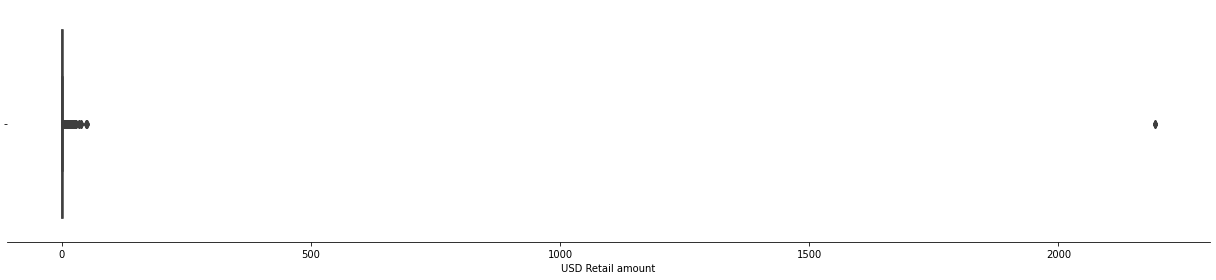

In [118]:
plt.figure(figsize = (17, 4))

sns.boxplot(ventas_merged['usd_retail_amount'])
sns.despine(left = True)

plt.xlabel('USD Retail amount')
plt.tight_layout();

**Hay un valor raro!!**

Damos un zoom despues de USD 200:

In [119]:
ventas_merged[ventas_merged['usd_retail_amount'] > 200]

,Delivery_Id,amount,Pais/Moneda,quantity,units,subtitle,ean (identificador producto),brand,variant,package_type,volume_quantity,volume_unit,nutritional_information,category_code,category_name,category_color,retail_amount,Date (YYYYMMDD),fecha,currency,weekday,fecha_wkend,date_curr_key,slug,close,usd_retail_amount,revenue
167180,16988,43956.0,México,1,1,Cloralex Desinfectante Antibacterial,75000592,Cloralex,Desinfectante Antibacterial,NaN,250.0,mL,NaN,LIMPIEZAMEX,LIMPIEZA,71DBCA,43956.0,20201130-180426175,2020-11-30,MXN,Mon,2020-11-30,2020-11-30MXN,USD/MXN,20.038071,2193.624326,2193.624326
167271,16988,43956.0,México,1,1,Cloralex Desinfectante Antibacterial,75000592,Cloralex,Desinfectante Antibacterial,NaN,250.0,mL,NaN,LIMPIEZAMEX,LIMPIEZA,71DBCA,43956.0,20201130-180426175,2020-11-30,MXN,Mon,2020-11-30,2020-11-30MXN,USD/MXN,20.038071,2193.624326,2193.624326
167273,16988,43956.0,México,1,1,Cloralex Desinfectante Antibacterial,75000592,Cloralex,Desinfectante Antibacterial,NaN,250.0,mL,NaN,LIMPIEZAMEX,LIMPIEZA,71DBCA,43956.0,20201130-180426175,2020-11-30,MXN,Mon,2020-11-30,2020-11-30MXN,USD/MXN,20.038071,2193.624326,2193.624326
167316,16988,43956.0,México,1,1,Cloralex Desinfectante Antibacterial,75000592,Cloralex,Desinfectante Antibacterial,NaN,250.0,mL,NaN,LIMPIEZAMEX,LIMPIEZA,71DBCA,43956.0,20201130-180426175,2020-11-30,MXN,Mon,2020-11-30,2020-11-30MXN,USD/MXN,20.038071,2193.624326,2193.624326
167318,16988,43956.0,México,1,1,Cloralex Desinfectante Antibacterial,75000592,Cloralex,Desinfectante Antibacterial,NaN,250.0,mL,NaN,LIMPIEZAMEX,LIMPIEZA,71DBCA,43956.0,20201130-180426175,2020-11-30,MXN,Mon,2020-11-30,2020-11-30MXN,USD/MXN,20.038071,2193.624326,2193.624326


No hay posibilidad de que un desifectante tenga un precio de **USD 2.193,62**!

Para corregirlo: 
- buscamos el valor del producto en un mercado mexicano (Walmart, por ejemplo);
- hacemos el cambio USD/MXN al día de hoy;
- substituimos el valor _abursdo_ con el valor obtenido arriba, más razonable.

In [120]:
# Conforme datos del sitio de Walmart Mexico
ventas_merged.loc[ventas_merged['ean (identificador producto)'] == '75000592', 'usd_retail_amount'] = 2.4463

Ahora hay que recalcular `revenue`, con los valores correctos:

In [121]:
# Recalculando con valores correctos
ventas_merged['revenue'] = ventas_merged['usd_retail_amount'] * ventas_merged['quantity']

Y revisitamos el grafico que nos dejo saber los valores _raros_:

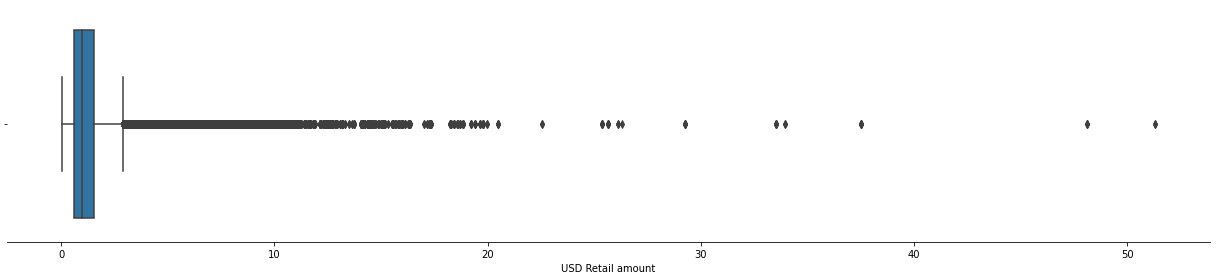

In [122]:
# Chequeamos si las cosas parecen más "normales" visualmente.
plt.figure(figsize = (17, 4))

sns.boxplot(ventas_merged['usd_retail_amount'])
sns.despine(left = True)

plt.xlabel('USD Retail amount')
plt.tight_layout();

**Un mercado con productos arriba de USD 50 es más acceptable.**

Pero por las dudas, damos un último zoom:

In [126]:
# Seleccionando registros con productos arriba de USD 50
ventas_merged[ventas_merged['usd_retail_amount'] > 50]

,Delivery_Id,amount,Pais/Moneda,quantity,units,subtitle,ean (identificador producto),brand,variant,package_type,volume_quantity,volume_unit,nutritional_information,category_code,category_name,category_color,retail_amount,Date (YYYYMMDD),fecha,currency,weekday,fecha_wkend,date_curr_key,slug,close,usd_retail_amount,revenue
148982,15137,182300.0,Colombian Peso,1,1,Buchanan's Whisky Malts Edition,5000196006027,Buchanan's,Whisky Malts Edition,NaN,750.0,mL,NaN,LICOR_Y_TABACO,LICOR,E193D1,182300.0,20210208-010519577,2021-02-08,COP,Mon,2021-02-08,2021-02-08COP,USD/COP,3553.75,51.297925,51.297925
148985,15137,182300.0,Colombian Peso,1,1,Buchanan's Whisky Malts Edition,5000196006027,Buchanan's,Whisky Malts Edition,NaN,750.0,mL,NaN,LICOR_Y_TABACO,LICOR,E193D1,182300.0,20210208-010519577,2021-02-08,COP,Mon,2021-02-08,2021-02-08COP,USD/COP,3553.75,51.297925,51.297925


**Un Whisky de USD 50 en Colombia parece razonable. Vamos bien!** 

~Debe ser un bon whisky (agregar a lista de compras)!~

### Guardando datos en un nuevo archivo `.csv`

Antes de guardar el dataset en un nuevo archivo `.csv`, que tal una limpieza tambien de variables?

Las variables del dataset son interesantes, pero para simplificar el analisis, elijimos llevar adelante apenas las más que generan KPIs más simples:

In [128]:
# Arrancamos oteniendo la lista de todas las variables
# ventas_merged.columns.tolist() # Descomente para generar la lista y pegar en la celda abajo

In [130]:
to_keep = [
 'Delivery_Id',
 'amount',
#  'Pais/Moneda',
 'quantity',
 'units',
 'subtitle',
 'ean (identificador producto)',
 'brand',
#  'variant',
#  'package_type',
#  'volume_quantity',
#  'volume_unit',
#  'nutritional_information',
#  'category_code',
#  'category_name',
#  'category_color',
 'retail_amount',
#  'Date (YYYYMMDD)',
 'fecha',
 'weekday',
 'currency',
#  'date_curr_key',
#  'fecha_wkend',
#  'date_curr_key_wkd',
#  'slug',
#  'close',
 'usd_retail_amount',
 'revenue'
]

#### Finalmente guardamos en `.csv` el dataset apenas con las variables eligidas:

In [132]:
# Descomentar para generar nuevo archivo .csv
# ventas_merged[to_keep].to_csv('../data/ventas_cleaned.csv', header = True, index = False)

Y el tradicional _sanity check_ para saber que guardamos todo bien:

In [135]:
pd.read_csv('../data/ventas_cleaned.csv').sample(7)

,Delivery_Id,amount,quantity,units,subtitle,ean (identificador producto),brand,retail_amount,fecha,weekday,currency,usd_retail_amount,revenue
60908,6401,2600.0,12,1,Pilsen,7702051002790,Pilsen,2600.0,2021-03-15,Mon,COP,0.742154,8.905851
9305,902,21.0,2,1,Modelo Especial Cerveza Clara,7501064191886,Modelo Especial,21.0,2020-07-08,Wed,MXN,0.921348,1.842695
67052,6984,4000.0,1,1,Colanta Queso Crema,7702129025201,Colanta,4000.0,2020-10-04,Sun,COP,1.040650,1.040650
311976,31828,5600.0,1,1,Postobn CO Gaseosa Manzana,7702090022728,Postobn CO,5600.0,2020-11-23,Mon,COP,1.542190,1.542190
34942,3576,145.0,3,1,Coca-Cola Sabor Original,7790895068164,Coca-Cola Sabor Original,145.0,2020-12-03,Thu,ARS,1.779469,5.338406
203024,19934,9.0,1,1,Quaker Barras de Avena de Mora,7501761838442,Quaker,9.0,2020-08-31,Mon,MXN,0.413795,0.413795
138916,14037,4.8,1,1,Piraque Biscoito Leite Maltado,7896024723482,Piraque,4.8,2020-10-23,Fri,BRL,0.858477,0.858477


**Todo listo! Proxima parada: Data Analysis**. 🚀